# Análise de projetos de infraestrutura com investimento federal no Distrito Federal


Teste avaliativo para vaga de bolsista em engenharia/análise de dados (LabLivre). Ver [material de referência](https://docs.google.com/document/d/1WWBnAodJoDo40WZ6ysI5cGx90KFYAp7GTFLrWPjmMFE/edit?tab=t.0)

Fonte de dados: [obrasgov](https://api.obrasgov.gestao.gov.br/obrasgov/api/swagger-ui/index.html#/Projeto%20De%20Investimento/buscarPorFiltro)

Relatório detalhado de tratamento de dados com visualizações. Para análises acessíveis ver a conclusão. Em resumo:

-   ... TODO

-   TOC

Observação: IA (Cursor) foi usado para a produção deste relatório, principalmente para agilizar a produção de gráficos.


In [274]:
import json
import time
import requests
import glob
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm

# cores do lablivre
palette = ["#412355", "#F2701C", "#18CEE6"]

## 1. Extração dos dados


In [275]:
# script de coleta de dados foi executado separadamente


def get_data(page: int) -> dict:
    url = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"
    params = {"uf": "DF", "pagina": page, "tamanhoDaPagina": 100}
    headers = {"accept": "*/*"}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to get data: {response.status_code}")

    return response.json()


def main():
    # inelegante mas eficiente. certamente não tem 10000 itens
    for page in range(100):
        response = get_data(page)
        print(f"Page {page} processed")

        # salvar dados brutos primeiro para não depender da api caso ocorram problemas
        with open(f"data/data-{page}.json", "w", encoding="utf-8") as f:
            json.dump(response["content"], f, indent=4)
        print(f"Data saved to data/data-{page}.json")

        time.sleep(1)

        page += 1


# if __name__ == "__main__":
#     main()

## 2. Tratamento de dados


In [276]:
def load_json_files() -> list[dict]:
    json_files = glob.glob("data/data-*.json")
    all_records = []

    for file in json_files:
        with open(file, "r", encoding="utf-8") as f:
            records = json.load(f)
            all_records.extend(records)

    return all_records


df = pd.DataFrame(load_json_files())

df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   idUnico                             834 non-null    object
 1   nome                                834 non-null    object
 2   cep                                 400 non-null    object
 3   endereco                            430 non-null    object
 4   descricao                           834 non-null    object
 5   funcaoSocial                        834 non-null    object
 6   metaGlobal                          834 non-null    object
 7   dataInicialPrevista                 832 non-null    object
 8   dataFinalPrevista                   832 non-null    object
 9   dataInicialEfetiva                  23 non-null     object
 10  dataFinalEfetiva                    7 non-null      object
 11  dataCadastro                        834 non-null    object

In [277]:
nested_cols = [
    "tomadores",
    "executores",
    "repassadores",
    "eixos",
    "tipos",
    "subTipos",
    "fontesDeRecurso",
]

### 2.1 Duplicatas


In [278]:
from analyse_duplicates import check_duplicates, analyze_false_duplicates

# existem duplicatas que só diferem no conteúdo das listas. não quero entediar você com esse código gerado por IA então movi para outro arquivo

check_duplicates(df)
analyze_false_duplicates(df, "results/duplicate_records_report")

Columns with lists: ['tomadores', 'executores', 'repassadores', 'eixos', 'tipos', 'subTipos', 'fontesDeRecurso']
Number of duplicate rows (not considering list columns): 122
Number of duplicate rows: 87
Number of 'false duplicate' rows: 70
Unique idUnico values in false duplicates: 35
Report written to duplicate_records_report.txt


In [279]:
# após investigação detalhada, todas as 'falsas duplicatas' se parecem com isso:

# Linha 133: [{'id': 90, 'descricao': 'Preservação do Patrimônio', 'idTipo': 5}] (5 = Administrativo)
# Linha 491: [{'id': 90, 'descricao': 'Preservação do Patrimônio', 'idTipo': 43}] (43 = Cultura)

# para mais exemplos, consulte o relatório (`results/duplicate_records_report.txt`).
# não tenho certeza do motivo disso; talvez os rótulos sejam ambíguos para as pessoas que preenchem algum formulário.
# mas isso parece indicar que são, de fato, duplicatas. então serão removidas.

df.duplicated(subset=["idUnico"]).sum()
df.drop_duplicates(subset=["idUnico"], inplace=True)

In [280]:
pd.set_option("display.max_columns", None)
df.head()

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
0,1828.53-16,SISEG - Sistema integrado de segurança,1,,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,None,None,2021-05-12,Recuperação,Projeto,,Cadastrada,None,DF,None,None,None,None,None,2021-05-12,[],"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
1,1711.53-18,Reforma do espelho d'água do Edifício-Sede do ...,1,,Reforma do espelho d'água do Edifício-Sede do ...,Reestabelecer a impermeabilização do espelho d...,Recuperação do sistema de impermeabilização e ...,2021-01-04,2021-05-18,None,None,2021-05-04,Reforma,Obra,,Cadastrada,None,DF,None,None,None,None,None,2021-05-04,"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...","[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
2,1989.53-01,Elaboração de projetos arquitetônicos e de eng...,1,"Campus Universitário Darcy Ribeiro, Brasília - DF",Contratação de empresa especializada para elab...,Obras para unidades acadêmicas de ensino e pes...,Elaboração de projetos de engenharia e Arquite...,2021-05-18,2021-09-29,None,None,2021-05-17,Construção,Projeto,None,Cadastrada,None,DF,None,None,None,None,None,2021-05-17,[],"[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'nome': 'FUNDACAO UNIVERSIDADE DE BRASILIA',...","[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 8, 'descricao': 'Educação', 'idEixo': 1}]","[{'id': 46, 'descricao': 'Instituições Federai...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
3,2004.53-58,SISEG - Sistema integrado de segurança,1,,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,None,None,2021-05-18,Recuperação,Projeto,,Cadastrada,None,DF,None,None,None,None,None,2021-05-18,[{'nome': 'BANCO CENTRAL DO BRASIL-ORC.FISCAL/...,"[{'nome': 'BANCO CENTRAL DO BRASIL', 'codigo':...",[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 59, 'descricao': 'Obras em Imóveis de ...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
4,2617.53-02,CENTRO DE FORMAÇÃO TECNOLOGICA - CFT - CAMPUS ...,1,"Área Especial n° 01, Quadra 16, Cidade do Auto...","construção um galpão com pé direito alto, que ...",atender a comunidade acadêmica do Campus Estru...,aumentar a oferta de cursos técnicos/tecnológi...,2020-12-01,2021-10-27,None,None,2021-06-18,Construção,Obra,,Cadastrada,triplicar as matrículas da educação profission...,DF,None,None,None,None,None,2021-06-18,[{'nome': 'INSTITUTO FED. ED. CIENCIA E TEC. D...,[{'nome': 'INSTITUTO FED. ED. CIENCIA E TEC. D...,"[{'nome': 'MINISTÉRIO DA EDUCAÇÃO', 'codigo': ...","[{'id': 4, 'descricao': 'Social'}]","[{'id': 46, 'descricao': 'Educação', 'idEixo':...","[{'id': 84, 'descricao': 'Educação', 'idTipo':...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."


### 2.2 Valores ausentes


In [281]:
# remover ceps preenchidos com 1 ou espaço.
df["cep"] = df["cep"].str.replace(r"^1$", "", regex=True)
df["cep"] = df["cep"].str.replace(r"\s+", "", regex=True).replace("", None)
df["cep"] = df["cep"].str.replace("-", "")
df["cep"] = df["cep"].str.replace(".", "")

# remover ceps com menos de 8 dígitos
df["cep"] = df["cep"].apply(lambda x: None if pd.isna(x) or len(str(x)) < 8 else x)

df["cep"].nunique()

90

In [282]:
# remover enderecos preenchidos com 1 ou espaço.
df["endereco"] = df["endereco"].str.strip()
df["endereco"] = df["endereco"].str.replace(r"^1$", "", regex=True)
df["endereco"] = df["endereco"].str.replace(r"^\s+$", "", regex=True).replace("", None)
df["endereco"].nunique()

238

In [283]:
object_cols = df.drop(columns=nested_cols, axis=1)
info_df = pd.DataFrame(
    {
        "Unique Values": object_cols.nunique(),
        "% Unique": (object_cols.nunique() / object_cols.count() * 100).round(1),
        "NaN Values": object_cols.isna().sum(),
        "% NaN": (object_cols.isna().sum() / len(object_cols) * 100).round(1),
    }
)
info_df[info_df["% NaN"] > 1].sort_values(by="% NaN", ascending=False)

,Unique Values,% Unique,NaN Values,% NaN
dataFinalEfetiva,5,100.0,707,99.3
dataInicialEfetiva,13,59.1,690,96.9
observacoesPertinentes,4,3.8,606,85.1
qdtEmpregosGerados,21,15.2,574,80.6
populacaoBeneficiada,30,21.4,572,80.3
descPopulacaoBeneficiada,42,29.2,568,79.8
naturezaOutras,38,20.0,522,73.3
cep,90,38.6,479,67.3
descPlanoNacionalPoliticaVinculado,78,31.5,464,65.2
endereco,238,76.3,400,56.2


Há muitos valores ausentes. Não entendo o motivo disso, mas não me parece um erro. Muitos desses são datas que suspeito serem futuras, ou campos do tipo 'outras observações'. Mais notável é a ausência de `qdtEmpregosGerados`, `populacaoBeneficiada`, `cep` e `endereco`. Não tiraria conclusões precipitadas sem saber mais.

Também não vejo necessidade de fazer imputação aqui. Então todos permanecem como estão.


### 2.3 Tipagem


In [284]:
# usar isso em cada coluna para verificar o tipo da variável
df["isModeladaPorBim"].value_counts(dropna=False)

isModeladaPorBim
False    471
None     216
True      25
Name: count, dtype: int64

In [285]:
df["isModeladaPorBim"] = df["isModeladaPorBim"].astype("boolean")

In [286]:
# variaveis categoricas
df["natureza"] = df["natureza"].astype("category")
df["situacao"] = df["situacao"].astype("category")
df["especie"] = df["especie"].astype("category")
df["uf"] = df["uf"].astype("category")

In [287]:
# variaveis de data
# verifiquei manualmente os registros para erros de formatação mas não encontrei problemas

date_cols = [
    "dataInicialPrevista",
    "dataFinalPrevista",
    "dataInicialEfetiva",
    "dataFinalEfetiva",
    "dataCadastro",
    "dataSituacao",
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

In [288]:
# alguns registros tem strings em vez de ints. esses registros também têm outros problemas; veja abaixo.
# isso coage strings para null
# converte para float em vez de int para permitir valores nulos
df["qdtEmpregosGerados"] = pd.to_numeric(df["qdtEmpregosGerados"], errors="coerce")
df["populacaoBeneficiada"] = pd.to_numeric(df["populacaoBeneficiada"], errors="coerce")

In [289]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 832
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   idUnico                             712 non-null    object        
 1   nome                                712 non-null    object        
 2   cep                                 233 non-null    object        
 3   endereco                            312 non-null    object        
 4   descricao                           712 non-null    object        
 5   funcaoSocial                        712 non-null    object        
 6   metaGlobal                          712 non-null    object        
 7   dataInicialPrevista                 710 non-null    datetime64[ns]
 8   dataFinalPrevista                   710 non-null    datetime64[ns]
 9   dataInicialEfetiva                  22 non-null     datetime64[ns]
 10  dataFinalEfetiva               

### 2.4 Colunas aninhadas


In [290]:
def normalize_nested_column(
    df: pd.DataFrame, id_col: str, nested_col: str
) -> pd.DataFrame:
    def convert_dict_values_to_str(x):
        # pd.json_normalize(df['tomadores'].explode()) converte o id para float, o que pode causar problemas devido à imprecisão de ponto flutuante mesmo se convertido de volta para int/str. por isso, preciso converter os valores para strings primeiro, o que requer um código um pouco confuso:

        if not isinstance(x, list):
            return x
        return [{key: str(value) for key, value in item.items()} for item in x]

    df[nested_col] = df[nested_col].apply(convert_dict_values_to_str)
    exploded = df[[id_col, nested_col]].explode(nested_col)
    exploded = exploded.dropna(subset=[nested_col])
    normalized = pd.json_normalize(exploded[nested_col])
    normalized[id_col] = exploded[id_col].values
    return normalized


def create_entity_table_from_junction_table(
    old_df: pd.DataFrame, prev_index: str, actual_index: str
) -> pd.DataFrame:
    new_df = old_df.dropna(subset=[prev_index])
    new_df.drop_duplicates(subset=[actual_index], inplace=True)
    new_df.set_index(actual_index, inplace=True)
    new_df.drop(prev_index, axis=1, inplace=True)
    return new_df

In [291]:
# reuni essas tabelas em uma só, pois são todas referentes a instituicoes e usam o mesmo sistema de códigos.

projeto_tomadores_df = normalize_nested_column(df, "idUnico", "tomadores")
projeto_executores_df = normalize_nested_column(df, "idUnico", "executores")
projeto_repassadores_df = normalize_nested_column(df, "idUnico", "repassadores")

tomadores_df = create_entity_table_from_junction_table(
    projeto_tomadores_df, "idUnico", "codigo"
)
executores_df = create_entity_table_from_junction_table(
    projeto_executores_df, "idUnico", "codigo"
)
repassadores_df = create_entity_table_from_junction_table(
    projeto_repassadores_df, "idUnico", "codigo"
)

instituicoes_df = pd.concat([tomadores_df, executores_df, repassadores_df])

# deduplicate indices
instituicoes_df = instituicoes_df.loc[~instituicoes_df.index.duplicated(keep="first")]

instituicoes_df.head(1)

,nome
codigo,
25280,BANCO CENTRAL DO BRASIL


In [292]:
projeto_eixos_df = normalize_nested_column(df, "idUnico", "eixos")

eixos_df = create_entity_table_from_junction_table(projeto_eixos_df, "idUnico", "id")

eixos_df.head(1)

,descricao
id,
1,Administrativo


In [293]:
projeto_tipos_df = normalize_nested_column(df, "idUnico", "tipos")

tipos_df = create_entity_table_from_junction_table(projeto_tipos_df, "idUnico", "id")

tipos_df.head(1)

,descricao,idEixo
id,,
5,Administrativo,1


In [294]:
projeto_subtipos_df = normalize_nested_column(df, "idUnico", "subTipos")

subtipos_df = create_entity_table_from_junction_table(
    projeto_subtipos_df, "idUnico", "id"
)

subtipos_df.head(1)

,descricao,idTipo
id,,
59,Obras em Imóveis de Uso Público,5


In [295]:
# nesse caso é one to many e nao many to many, entao nao precisa da tabela intermediaria. mas reutiliza o codigo de qualquer forma

fontes_de_recurso_df = normalize_nested_column(
    df, "idUnico", "fontesDeRecurso"
).reset_index(drop=True)

# nesse caso estava certo o float
fontes_de_recurso_df["valorInvestimentoPrevisto"] = pd.to_numeric(
    fontes_de_recurso_df["valorInvestimentoPrevisto"], errors="coerce"
)

fontes_de_recurso_df.head(1)

,origem,valorInvestimentoPrevisto,idUnico
0,Federal,23427554.88,1828.53-16


In [296]:
df.drop(columns=nested_cols, inplace=True)

### 2.X Limpeza de dados


#### Encoding


In [297]:
# erro de encoding. todos parecem seguir nomes parecidos, indicando que o erro deve ser relacionado à fonte. endereço são rodovias.
# Texto em UTF-8, foi lido como Latin-1 (ISO-8859-1)
enconding_issue = df[df["descricao"].str.contains("Ã§Ã")]
print(f"Pelo menos {enconding_issue.shape[0]} projetos com erro de encoding")
df[df["descricao"].str.contains("Ã§Ã")].head(1)

Pelo menos 18 projetos com erro de encoding


,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao
63,6015.53-53,00 00692/2020,70040902,BR-010,prestaÃ§Ã£o dos serviÃ§os de gerenciamento dos...,Preservar vidas e promover o desenvolvimento s...,Gerenciamento de 0 km.,2021-01-18,2024-01-02,NaT,NaT,2022-05-10,Construção,Obra,None,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2022-05-10


In [298]:
def fix_encoding(item: any) -> any:
    if isinstance(item, str):
        try:
            return item.encode("latin-1").decode("utf-8")
        except:
            return item
    return item


for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].apply(fix_encoding)

#### Registros incorretos devido a testes de integração


In [299]:
# há um sujeito chamado Ronald Alves Vieira e ele está testando em produção
test_df = df[df["nome"].str.contains("Ronald", case=False, na=False)]
test_df.head()

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao
79,4543.53-79,202111-22-Ronald 1,70067901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,NaT,NaT,2021-11-17,Fabricação,Projeto,outros,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-11-17
80,4540.53-87,202111-22-Ronald 1,70067901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,NaT,NaT,2021-11-17,Reforma,Obra,outros,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-11-17
82,4542.53-01,202111-22-Ronald 1,70067901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,NaT,NaT,2021-11-17,Reforma,Projeto de Investimento em Infraestrutura,outros,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-11-17
83,4544.53-36,202111-22-Ronald 1,70067901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,NaT,NaT,2021-11-17,Reforma,Projeto de Investimento em Infraestrutura,outros,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-11-17
205,4541.53-44,202111-22-Ronald 1,70067901,2021122-Ronald - Endereço Completo,2021122-Ronald - Descrição do Projeto,2021122-Ronald - Descrição Funç]ap Social,20211122-Ronald - Descrição Meta Global,2021-12-10,2021-12-10,NaT,NaT,2021-11-17,Recuperação,Projeto de Investimento em Infraestrutura,outros,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-11-17


In [300]:
# é possível que hajam mais casos que não encontrei
# é possível que essa limpeza remova dados reais


antes = df.shape[0]

df = df[~df["nome"].str.contains("Ronald", case=False, na=False)]
df = df[~df["nome"].str.contains("Teste", case=False, na=False)]

depois = df.shape[0]

print(
    f"Removidos {antes - depois} projetos por serem registros falsos (efeitos colaterais de testes de integração)"
)

Removidos 22 projetos por serem registros falsos (efeitos colaterais de testes de integração)


### 2.5 Carregamento de dados


In [301]:
with sqlite3.connect("projeto_investimento.db") as con:
    # main
    df.to_sql("projeto_investimento", con, if_exists="replace")

    # entity tables
    instituicoes_df.to_sql("instituicoes", con, if_exists="replace")
    eixos_df.to_sql("eixos", con, if_exists="replace")
    tipos_df.to_sql("tipos", con, if_exists="replace")
    subtipos_df.to_sql("subtipos", con, if_exists="replace")
    fontes_de_recurso_df.to_sql("fontes_de_recurso", con, if_exists="replace")

    # junction tables
    projeto_tomadores_df.to_sql("projeto_tomadores", con, if_exists="replace")
    projeto_executores_df.to_sql("projeto_executores", con, if_exists="replace")
    projeto_repassadores_df.to_sql("projeto_repassadores", con, if_exists="replace")
    projeto_eixos_df.to_sql("projeto_eixos", con, if_exists="replace")
    projeto_tipos_df.to_sql("projeto_tipos", con, if_exists="replace")
    projeto_subtipos_df.to_sql("projeto_subtipos", con, if_exists="replace")

In [302]:
# with sqlite3.connect("projeto_investimento.db") as con:
#     df = pd.read_sql_query("SELECT * FROM projeto_investimento", con)

### 2.5 Engenharia de características


Criação de novas colunas para fins de análise

-   `textoTotal`: concatenação de dados textuais de um registro para processamento de linguagem natural (NLP)
-   `investimentoTotal`: consolidação de `fontesDeRecurso` para análise quantitativa
-   `investimentoFaixa`: versão categórica de `investimentoTotal` por faixas (por exemplo, de 100 a 1000, de 1,000 a 10,000, etc.)
-   `isInvestimentoSimbolico`: investimentos com valores menores que 1 real; assume-se que possuem valor simbólico
-   `duracaoPrevista`: calcular duração prevista de projetos (via `dataInicialPrevista`, `dataFinalPrevista`)
-   `lat`, `lon`: obtenção de dados geográficos (via `cep`) usando geocoding para visualização gráfica
-   calcular


In [303]:
# textoTotal

text_cols = [
    "nome",
    "endereco",
    "descricao",
    "funcaoSocial",
    "metaGlobal",
    "especie",
    "natureza",
    "naturezaOutras",
    "situacao",
    "descPlanoNacionalPoliticaVinculado",
    "descPopulacaoBeneficiada",
    "observacoesPertinentes",
]


def make_text_total(row):
    text_total = []
    for x in row:
        if pd.notna(x):
            text_total.append(str(x))
    return "\n\n".join(text_total)


df["textoTotal"] = df[text_cols].apply(make_text_total, axis=1)

In [304]:
# investimentoTotal

valor_por_id = (
    fontes_de_recurso_df.groupby("idUnico")["valorInvestimentoPrevisto"]
    .sum()
    .reset_index()
)

valor_por_id.rename(
    columns={"valorInvestimentoPrevisto": "investimentoTotal"}, inplace=True
)

df = df.merge(valor_por_id, on="idUnico", how="left", validate="one_to_one")

In [305]:
# investimentoFaixa

bins = [
    0,
    1,
    10,
    100,
    1_000,
    10_000,
    100_000,
    1_000_000,
    10_000_000,
    100_000_000,
    1_000_000_000,
    np.inf,
]
labels = [
    "<1",
    "1-10",
    "10-100",
    "100-1k",
    "1k-10k",
    "10k-100k",
    "100k-1M",
    "1M-10M",
    "10M-100M",
    "100M-1B",
    ">1B",
]

df["investimentoFaixa"] = pd.cut(df["investimentoTotal"], bins=bins, labels=labels)

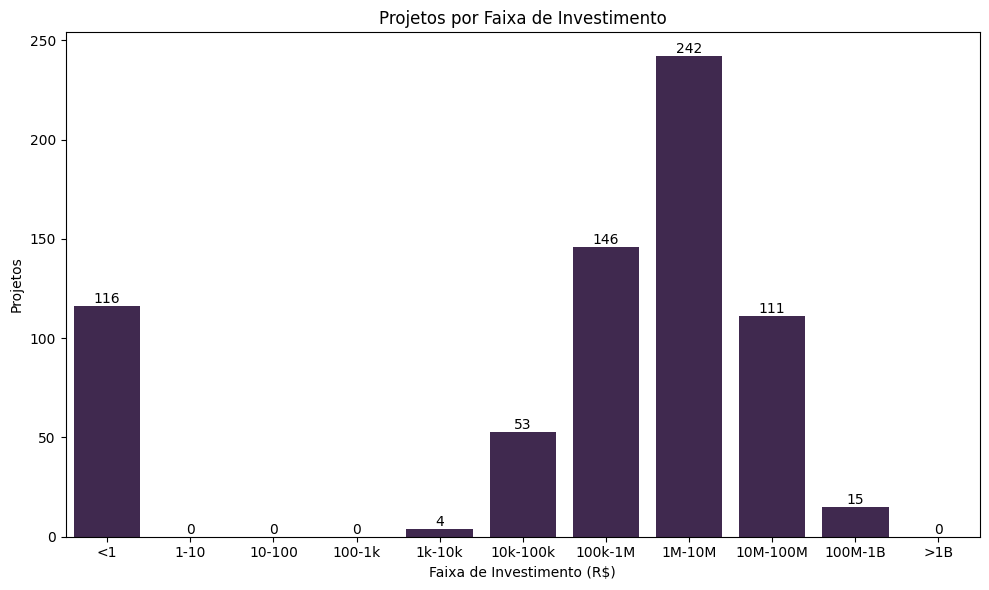

In [306]:
# equivalente a escala logaritmica
faixa_counts = df["investimentoFaixa"].value_counts().reset_index()
faixa_counts.columns = ["investimentoFaixa", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=faixa_counts,
    x="investimentoFaixa",
    y="count",
    hue="investimentoFaixa",
    palette=[palette[0] for _ in range(len(faixa_counts))],
)

# custom palette creates multiple containers
for container in ax.containers:
    ax.bar_label(container)  # type: ignore

plt.xlabel("Faixa de Investimento (R$)")
plt.ylabel("Projetos")
plt.title("Projetos por Faixa de Investimento")
plt.tight_layout()
plt.show()

In [307]:
# isInvestimentoSimbolico

df["isInvestimentoSimbolico"] = df["investimentoTotal"] <= 1
df["isInvestimentoSimbolico"].value_counts()

isInvestimentoSimbolico
False    571
True     119
Name: count, dtype: int64

In [308]:
# duracaoPrevista
df["duracaoPrevista"] = df["dataFinalPrevista"] - df["dataInicialPrevista"]

In [309]:
# lat, lon

# todo

## 3. Análise


### 3.1 Informações básicas

**Colunas:**

-   **texto**

    -   dados básicos: `idUnico`, `nome`, `descricao`, `funcaoSocial`, `metaGlobal`
    -   descrições opcionais: `naturezaOutras`, `descPlanoNacionalPoliticaVinculado`, `descPopulacaoBeneficiada`, `observacoesPertinentes`
    -   criada: `textoTotal`,

-   **geográfico**

    -   `cep`, `endereco`
    -   criada: `lat`, `lon`

-   **numéricos**

    -   `qdtEmpregosGerados`
    -   `populacaoBeneficiada`
    -   criada: `investimentoTotal`

-   **datas**

    -   `dataInicialPrevista`, `dataFinalPrevista`, `dataInicialEfetiva`, `dataFinalEfetiva`, `dataCadastro`, `dataSituacao`
    -   criada: `duracaoPrevista`

-   **categorias**

    -   `natureza` (Estudo, Obra, Outros, Projeto, Projeto de Investimento em Infraestrutura)
    -   `situacao` (Cadastrada, Cancelada, Concluída, Em execução, Inacabada, Inativada, Paralisada)
    -   `especie` (Ampliação, Construção, Fabricação, Máquinas e Equipamentos, Recuperação, Reforma)
    -   `uf` (DF)
    -   `isModeladaPorBim` (boolean)
    -   criada: `investimentoFaixa` (boolean)
    -   criada: `isInvestimentoSimbolico` (boolean)

-   **colunas aninhadas** (removidas após normalização)
    -   `tomadores`, `executores`, `repassadores`, `eixos`, `tipos`, `subTipos`, `fontesDeRecurso`

**Registros:** 712 (após deduplicação de 834 registros originais)

**Valores ausentes mais significativos:**

-   `dataFinalEfetiva`: 707 nulos (99.3%)
-   `dataInicialEfetiva`: 690 nulos (96.9%)
-   `qdtEmpregosGerados`: 677 nulos (95.1%)
-   `populacaoBeneficiada`: 677 nulos (95.1%)
-   `endereco`: 337 nulos (47.3%)
-   `cep`: 365 nulos (51.3%)
-   `descPlanoNacionalPoliticaVinculado`: 464 nulos (65.2%)
-   `isModeladaPorBim`: 216 nulos (30.3%)

As colunas aninhadas foram normalizadas e separadas em tabelas relacionadas no banco de dados SQLite, incluindo tabelas de entidades (instituições, eixos, tipos, subtipos, fontes de recurso) e tabelas de junção (projeto_tomadores, projeto_executores, projeto_repassadores, projeto_eixos, projeto_tipos, projeto_subtipos).

Tomadores, executores e repassadores partilham do mesmo sistema de códigos e portanto estão armazenados na mesma tabela.

Eixos, tipos, subtipos poderiam ser armazenados na mesma tabela com perda de normalização mas ganho em simplicidade.


### 3.2 Qualidade


Em questão de anomalias, temos:

1.  duplicados que diferem apenas no subtipo, como: dois registros com id 15 e mesma descrição "Aquisição de Máquinas e Equipamentos", mas idTipo diferentes (41 e 14).

2.  organizacoes com mais de um codigo, como: "PRESIDÊNCIA DA REPÚBLICA" (codigo 26) e "Presidencia da República" (codigo 20000)

3.  Vários campos (`cep`, `endereco`, `qdtEmpregosGerados`) preenchidos com um espaço em branco, dando a impressão que tem menos nulos do que realmente tem.

    4.  CEPs preenchidos errado (`1` e ' ')
    5.  125 registros similares com os mesmos problemas (' ' em vez de int em `qdtEmpregosGerados` e `populacaoBeneficiada`)

4.  Registro de teste (`22312.53-84`), encontrado porque é o único com dois investimentos, os dois com valor de um centavo.

5.  `descPopulacaoBeneficiada` com texto padrão

6.  `descPlanoNacionalPoliticaVinculado`: alguns usuários tratam como valor categórico e outros como texto

7.  `populacaoBeneficiada` alguns registros todos em maiusculo ('CONSTRUÇÃO DO NOVO IML DA PCDF')

8.  alguns nomes são apenas códigos (`26.782.2087.7T98.0025`)

9.  22 registros são testes e foram descartados; alguns possuem valores de investimento que poderam distorcer análises. alguns são mais obviamente testes (`40456.53-49`) do que outros (`2843.53-36`)

10. 8 projetos com exatamente 50 empregos gerados sem relação aparente entre si

    -   idUnico: 11486.53-40, 19176.53-10, 30067.53-80, 31923.53-48,9854.53-01, 91397.53-15, 91392.53-43, 31897.53-36.

11. projetos com investimento entre 1 e 10 milhões com duração prevista de zero dias.

12. `cep` preenchido com 7000000, ou com menos que 8 dígitos

Sem mais informações sobre o domínio, é dificil comentar o significado dessas questões. Mas são algo a ser investigado. Possivelmente, isso indica confusão pela parte dos usuários, ou falta de adequação entre os campos do formulário e a realidade dos projetos. De qualquer forma, uma forma de reduzir isso seria incluir validação antes de salvar no banco de dados (por exemplo, recusar o CEP '1') ou transformá-los antes de inserir (por exemplo, converter o CEP ' ' para nulo)


### 3.3 Descritiva


#### 3.3.1 Variáveis categóricas


In [310]:
df.head(5)

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao,textoTotal,investimentoTotal,investimentoFaixa,isInvestimentoSimbolico,duracaoPrevista
0,1828.53-16,SISEG - Sistema integrado de segurança,None,None,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,NaT,NaT,2021-05-12,Recuperação,Projeto,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-12,SISEG - Sistema integrado de segurança\n\nimpl...,23427554.88,10M-100M,False,1828 days
1,1711.53-18,Reforma do espelho d'água do Edifício-Sede do ...,None,None,Reforma do espelho d'água do Edifício-Sede do ...,Reestabelecer a impermeabilização do espelho d...,Recuperação do sistema de impermeabilização e ...,2021-01-04,2021-05-18,NaT,NaT,2021-05-04,Reforma,Obra,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-04,Reforma do espelho d'água do Edifício-Sede do ...,139328.54,100k-1M,False,134 days
2,1989.53-01,Elaboração de projetos arquitetônicos e de eng...,None,"Campus Universitário Darcy Ribeiro, Brasília - DF",Contratação de empresa especializada para elab...,Obras para unidades acadêmicas de ensino e pes...,Elaboração de projetos de engenharia e Arquite...,2021-05-18,2021-09-29,NaT,NaT,2021-05-17,Construção,Projeto,None,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-17,Elaboração de projetos arquitetônicos e de eng...,1399545.52,1M-10M,False,134 days
3,2004.53-58,SISEG - Sistema integrado de segurança,None,None,implantação dos sistemas de monitoramento por ...,implantação dos sistemas de monitoramento por ...,Modernização do sistema de segurança do Banco ...,2019-02-04,2024-02-06,NaT,NaT,2021-05-18,Recuperação,Projeto,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2021-05-18,SISEG - Sistema integrado de segurança\n\nimpl...,23427554.88,10M-100M,False,1828 days
4,2617.53-02,CENTRO DE FORMAÇÃO TECNOLOGICA - CFT - CAMPUS ...,None,"Área Especial n° 01, Quadra 16, Cidade do Auto...","construção um galpão com pé direito alto, que ...",atender a comunidade acadêmica do Campus Estru...,aumentar a oferta de cursos técnicos/tecnológi...,2020-12-01,2021-10-27,NaT,NaT,2021-06-18,Construção,Obra,,Cadastrada,triplicar as matrículas da educação profission...,DF,NaN,None,NaN,None,<NA>,2021-06-18,CENTRO DE FORMAÇÃO TECNOLOGICA - CFT - CAMPUS ...,1862560.00,1M-10M,False,330 days


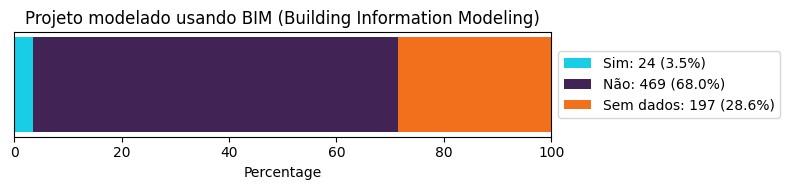

In [311]:
palette_bool = ["#18CEE6", "#412355", "#F2701C"]

# Convert and reorder
bim_map = {True: "Sim", False: "Não"}
bim_counts = (
    df["isModeladaPorBim"].map(bim_map).fillna("Sem dados").value_counts(dropna=False)
)

# Specify custom order
desired_order = ["Sim", "Não", "Sem dados"]
bim_counts = bim_counts.reindex(desired_order)
percentages = bim_counts / bim_counts.sum() * 100

# Create stacked bar
fig, ax = plt.subplots(figsize=(8, 2))
left = 0
colors = [palette_bool[i] for i in range(len(bim_counts))]
for i, (label, pct) in enumerate(zip(bim_counts.index, percentages)):
    ax.barh(
        0,
        pct,
        left=left,
        color=colors[i],
        label=f"{label}: {bim_counts.iloc[i]} ({pct:.1f}%)",
    )
    left += pct

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Percentage")
ax.set_title("Projeto modelado usando BIM (Building Information Modeling)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Apenas 3.5% dos projetos usou BIM, enquanto 66.2% não usou.


In [312]:
def make_barh_plot(
    df: pd.DataFrame,
    column: str,
    title: str,
    color: str,
    extra_space: float = 1,
    show_percentages: bool = False,
):
    plt.figure(figsize=(10, 6))

    # Get counts and percentages
    value_counts = df[column].value_counts(dropna=False)
    percentages = (value_counts / len(df)) * 100

    # Create DataFrame with both counts and percentages
    value_counts_df = pd.DataFrame(
        {"count": value_counts, column: value_counts.index, "percentage": percentages}
    ).reset_index(drop=True)

    ax = sns.barplot(
        data=value_counts_df,
        x="count",
        y=column,
        hue=column,
        orient="h",
        order=value_counts_df[column],
        palette=[color for _ in range(len(value_counts_df))],
        legend=False,
    )

    # Add labels with count and optionally percentage
    for i, v in enumerate(value_counts_df["count"]):
        if show_percentages:
            label = f"{int(v)} ({percentages[i]:.1f}%)"
        else:
            label = f"{int(v)}"
        ax.text(v + 5, i, label, va="center")  # padding

    # Extend x-axis to accommodate labels
    max_val = value_counts_df["count"].max()
    ax.set_xlim(0, max_val * extra_space)

    plt.title(title)
    plt.xlabel("Quantidade")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

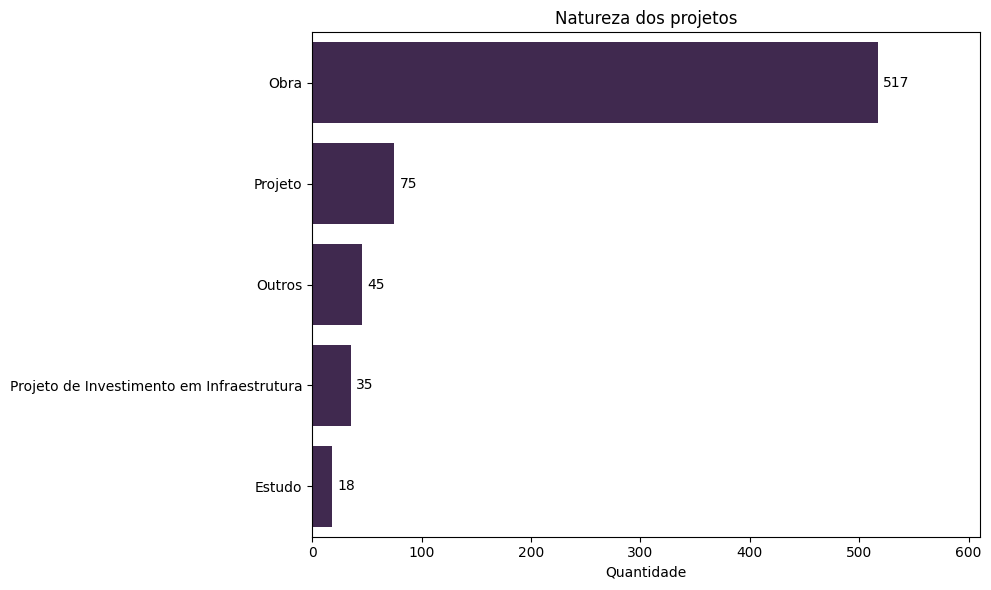

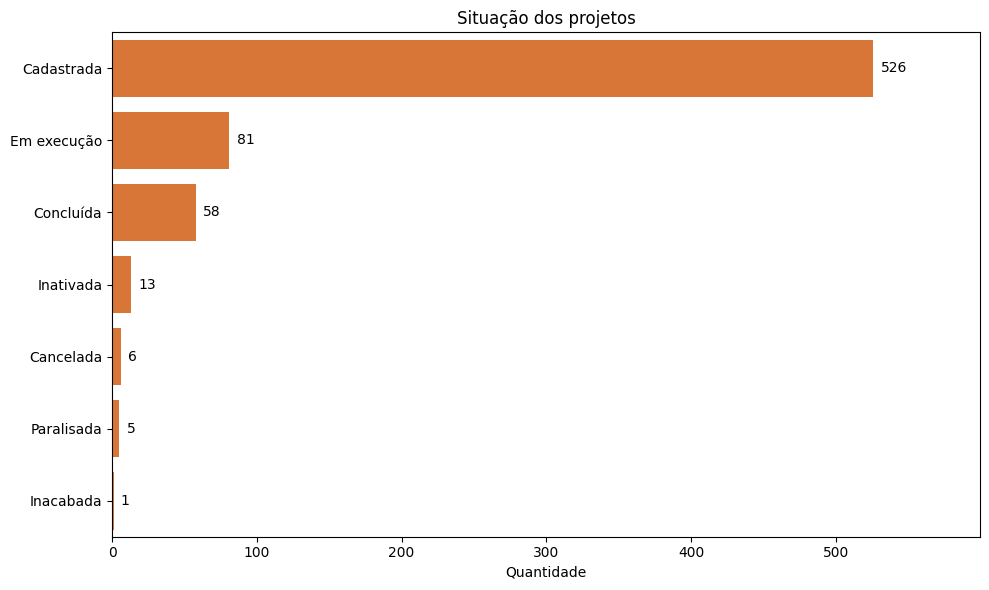

/tmp/ipykernel_102879/3272935303.py:20: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  ax = sns.barplot(


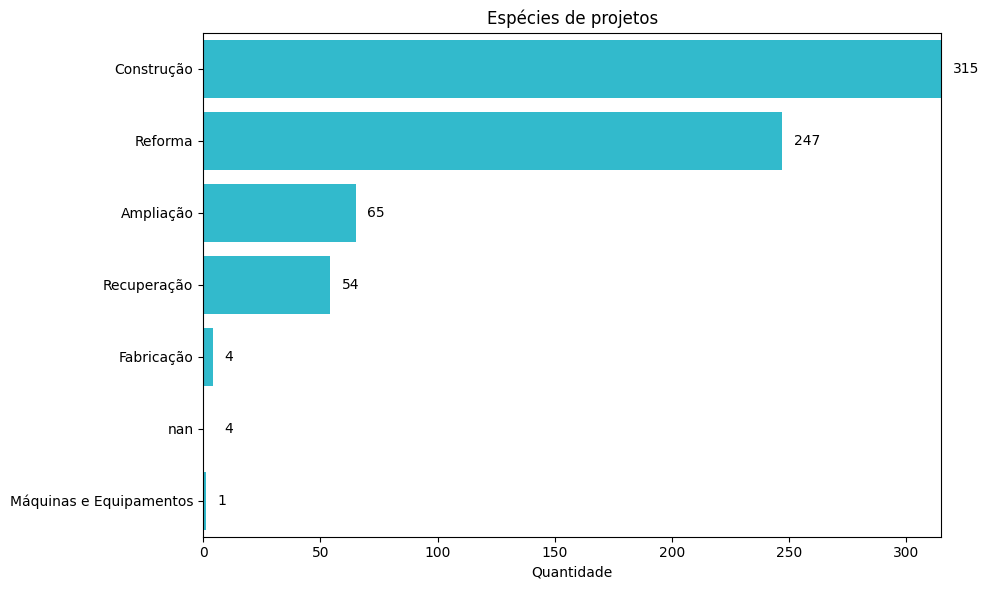

In [313]:
make_barh_plot(df, "natureza", "Natureza dos projetos", palette[0], extra_space=1.18)

make_barh_plot(df, "situacao", "Situação dos projetos", palette[1], extra_space=1.14)

make_barh_plot(df, "especie", "Espécies de projetos", palette[2])

---

Resumo das variáveis categóricas:

-   **BIM**: Apenas 3.5% dos projetos usou BIM, enquanto 66.2% não usou.
-   **Natureza dos projetos**: A grande maioria dos itens (73%) é classificado como obra, e não como projeto ou projeto de investimento em infraestrutura.
-   **Situação dos projetos**: 76% projetos estão cadastrados, com 11% em execução, 8% concluídos e 3% inativados, cancelados, paralisados ou inacabados.
-   **Espécies de projetos**: 44% construção de novos projetos e 54% reforma, ampliação ou recuperação de projetos existentes.


#### 3.3.2 Variáveis quantitativas


In [314]:
count = len(df["qdtEmpregosGerados"])
nans = df["qdtEmpregosGerados"].isna().sum()
print(f"NaN percentage for qdtEmpregosGerados: {nans/count*100:.1f}%")

count = len(df["populacaoBeneficiada"])
nans = df["populacaoBeneficiada"].isna().sum()
print(f"NaN percentage for populacaoBeneficiada: {nans/count*100:.1f}%")

both_nan = df[df["qdtEmpregosGerados"].isna() & df["populacaoBeneficiada"].isna()]
print(f"Number of rows where both values are NaN: {len(both_nan)/len(df)*100:.1f}%")
print()
print(
    f'Non-nan values in both columns: {len(df[df["qdtEmpregosGerados"].notna() & df["populacaoBeneficiada"].notna()])}'
)
print(
    f'Non-nan values in qdtEmpregosGerados: {len(df[df["qdtEmpregosGerados"].notna()])}'
)
print(
    f'Non-nan values in populacaoBeneficiada: {len(df[df["populacaoBeneficiada"].notna()])}'
)

NaN percentage for qdtEmpregosGerados: 94.9%
NaN percentage for populacaoBeneficiada: 94.9%
Number of rows where both values are NaN: 94.3%

Non-nan values in both columns: 31
Non-nan values in qdtEmpregosGerados: 35
Non-nan values in populacaoBeneficiada: 35


In [315]:
# quant_df = df[df["qdtEmpregosGerados"].notna() & df["populacaoBeneficiada"].notna()]

# make_barh_plot(
#     quant_df, "natureza", "Natureza dos projetos", palette[0], show_percentages=False
# )

# make_barh_plot(
#     quant_df, "situacao", "Situacao de projetos", palette[1], show_percentages=False
# )

# make_barh_plot(
#     quant_df, "especie", "Especies de projetos", palette[2], show_percentages=False
# )

Devemos considerar que estes dados estão faltando em 95% dos registros. Apesar disso, os 5% dos projetos com dados quantitativos parecem possuir a mesma distribuição da amostra geral (conferme célula anterior, removida por simplicidade) -- não são apenas projetos em execução/concluídos, como eu imaginava. Portanto, isso sugere que é uma questão de problemas de coleta de dados, e não de que esses dados só existem quando um projeto é executado ou concluído.


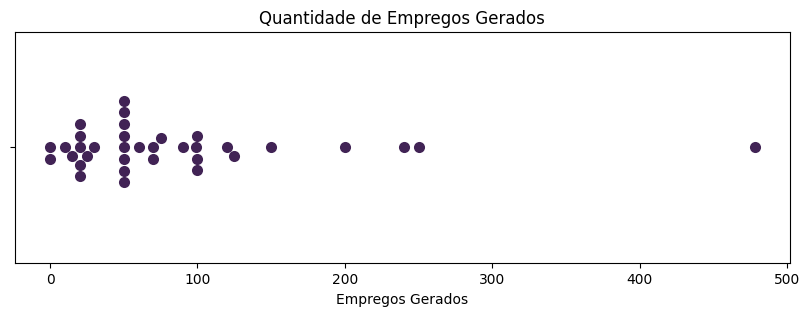

In [316]:
# swarm plot escolhido em vez de histograma pois só há 35 observações
plt.figure(figsize=(10, 3))
sns.swarmplot(data=df, x="qdtEmpregosGerados", size=8, color=palette[0])
plt.title("Quantidade de Empregos Gerados")
plt.xlabel("Empregos Gerados")
plt.show()

In [317]:
# outlier de empregos gerados
df[["idUnico", "nome", "descricao", "qdtEmpregosGerados"]].sort_values(
    by="qdtEmpregosGerados", ascending=False
).head(1)

,idUnico,nome,descricao,qdtEmpregosGerados
78,10834.53-24,CONSTRUÇÃO DO NOVO IML DA PCDF,Construção do novo Instituto de Medicina Legal...,478.0


In [318]:
# pq tem 8 projetos com exatamente 50 empregos gerados?
qtd_mode = df["qdtEmpregosGerados"].mode().values[0]
print(f"Mode value: {qtd_mode}")
print(
    f"Number of projects with mode value: {len(df[df['qdtEmpregosGerados'] == qtd_mode])}"
)

Mode value: 50.0
Number of projects with mode value: 8


/home/noah-art3mis/projects/takehome-lablivre-analysis/.venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


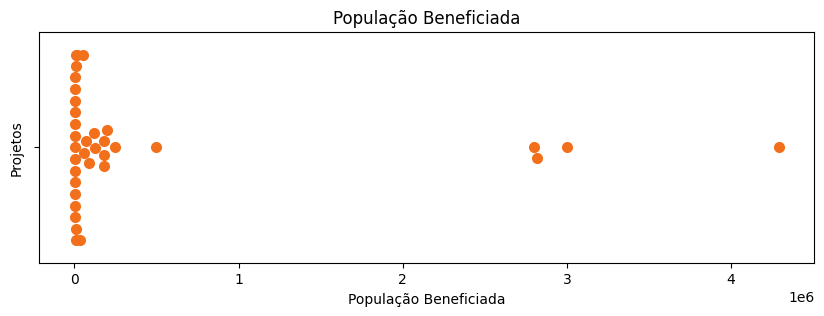

In [319]:
plt.figure(figsize=(10, 3))
sns.swarmplot(data=df, x="populacaoBeneficiada", size=8, color=palette[1])
plt.title("População Beneficiada")
plt.xlabel("População Beneficiada")
plt.ylabel("Projetos")
plt.show()

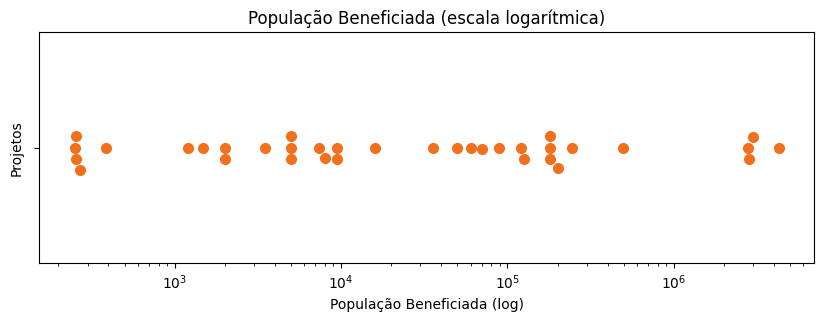

In [320]:
# distribuição melhor visualizada com escala logaritmica
plt.figure(figsize=(10, 3))
sns.swarmplot(
    data=df, x="populacaoBeneficiada", size=8, color=palette[1], log_scale=True
)
plt.title("População Beneficiada (escala logarítmica)")
plt.xlabel("População Beneficiada (log)")
plt.ylabel("Projetos")
plt.show()

In [321]:
# Outliers de população beneficiada
df[["idUnico", "nome", "populacaoBeneficiada"]].sort_values(
    by="populacaoBeneficiada", ascending=False
).head(4)

,idUnico,nome,populacaoBeneficiada
78,10834.53-24,CONSTRUÇÃO DO NOVO IML DA PCDF,4291577.0
596,10798.53-55,Construção das Novas Instalações do Centro de ...,3000000.0
456,50954.53-97,"Construção do Museu da Imagem e do Som, em Bra...",2817381.0
349,31923.53-48,Reforma de Quadras Poliesportivas,2800000.0


##### Investimento


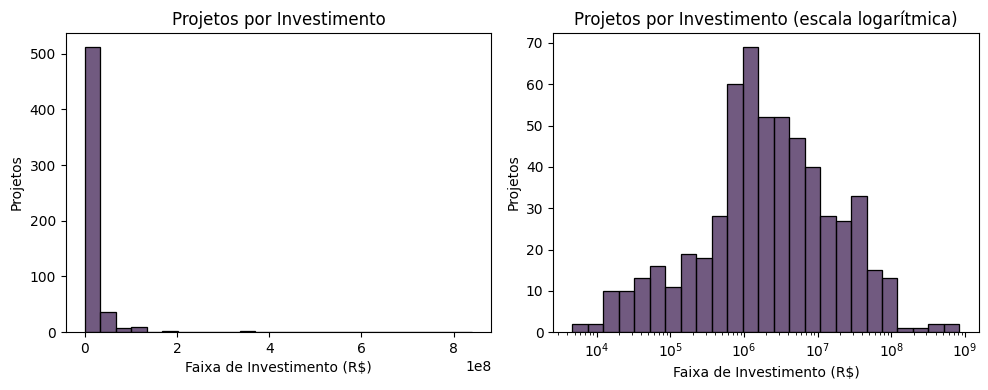

In [322]:
# Plot normal scale
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(
    data=df[~df["isInvestimentoSimbolico"]],
    x="investimentoTotal",
    bins=25,
    color=palette[0],
)
plt.xlabel("Faixa de Investimento (R$)")
plt.ylabel("Projetos")
plt.title("Projetos por Investimento")

# Plot log scale
plt.subplot(1, 2, 2)
sns.histplot(
    data=df[~df["isInvestimentoSimbolico"]],
    x="investimentoTotal",
    bins=25,
    color=palette[0],
    log_scale=True,
)
plt.xlabel("Faixa de Investimento (R$)")
plt.ylabel("Projetos")
plt.title("Projetos por Investimento (escala logarítmica)")

plt.tight_layout()
plt.show()

In [323]:
df[~df["isInvestimentoSimbolico"]]["investimentoTotal"].describe().apply(
    lambda x: f"{x:,.2f}"
)

count            571.00
mean      13,871,387.02
std       51,931,177.66
min            4,684.45
25%          667,980.23
50%        2,085,189.23
75%        8,402,637.63
max      839,664,954.32
Name: investimentoTotal, dtype: object

In [324]:
def calculate_iqr(data: pd.Series) -> float:
    q75 = data.quantile(0.75)
    q25 = data.quantile(0.25)
    return q75 - q25


valores = df[~df["isInvestimentoSimbolico"]]["investimentoTotal"]
iqr = calculate_iqr(valores)
print(f"IQR: R$ {iqr:,.2f}")

IQR: R$ 7,734,657.40


Após selecionar apenas of projetos com investimentos significativos, vemos uma distribuição aproximadamente log-normal (comum com este tipo de dado não-negativo, como dinheiro). Isso significa que grandes investimento são exponencialmente mais raros que os casos de investimento menor.

Isso também significa que a média é pouco informativa sobre os dados; podemos usar mediana e IQR para ter uma ideia melhor

Ela apresenta, aproximadamente:

-   Variação entre 4 mil e 800 milhões
-   Mediana (valor que divide os dados ao meio): 2 milhões
-   IQR (amplitude interquartil): 8 milhões
-   Cerca de 50% dos projetos entre 1 e 8 milhões.

Assim, isso também indica que os valores mais altos não são outliers, mas são parte da distribuição log-normal.


In [325]:
# valores altos
df[["descricao", "investimentoTotal"]].sort_values(
    by="investimentoTotal", ascending=False
).head(10)

,descricao,investimentoTotal
117,"Projeto Estratégico do SISFRON, cujo objeto é ...",8.396650e+08
532,CONSTRUCAO DE CONTORNO RODOVIARIO - NO MUNICIP...,5.961359e+08
549,ADEQUACAO DE TRECHO RODOVIARIO - ENTRONCAMENTO...,3.591301e+08
516,"execução das obras de adequação de capacidade,...",3.529946e+08
13,Contratação de empresa para prestação de servi...,2.014046e+08
172,contratação de empresa para a prestação de ser...,1.934674e+08
452,Contratação de empresa para prestação de servi...,1.196893e+08
268,(TED nº 03/2017) - Instalação de Estações Mete...,1.186510e+08
415,Contratação de serviços técnicos especializado...,1.129367e+08
341,Execução de Serviços do Programa CREMA - Recup...,1.123280e+08


Várias creches parecem receber investimentos com valor simbólico.

Valores mais altos de investimento incluem:

-   SISFRON (Sistema Integrado de Monitoramento de Fronteiras): R$ 840 milhões
-   Obras rodoviárias R$ 596, R$ 359, R$ 353 milhões
-   Asessoramentos diversos: 193, 119, 112 milhões
-   Instalação de Estações Metereológicas: 118 milhões

Como só há 5% de não-nulos nas outras categorias quantitativas, opto por não calcular correlação e etc.


In [326]:
# valores baixos simbólicos
df[["nome", "investimentoTotal"]].sort_values(
    by="investimentoTotal", ascending=True
).head()

,nome,investimentoTotal
67,contratação de empresa especializada em engenh...,0.00
372,"Construção, Reforma e Ampliação dos Prédios da...",0.00
232,OBRA DE REFORMA DO ACESSO PRINCIPAL DA FACULDA...,0.00
491,PAC 2 - CRECHE/PRÉ-ESCOLA 066,0.01
492,PAC 2 - CRECHE/PRÉ-ESCOLA 067,0.01


In [327]:
# valores baixos não-simbólicos
df[~df["isInvestimentoSimbolico"]][["nome", "investimentoTotal"]].sort_values(
    by="investimentoTotal", ascending=True
).head()

,nome,investimentoTotal
374,Projetos e estudos técnicos para obras 16º BPM...,4684.45
392,Projeto de monitoramento eletrônico e alarmes ...,7500.00
49,contratação de empresa especializada para elab...,8000.00
342,CORPO DE BOMBEIROS MILITAR DO DISTRITO FEDERAL,10000.00
24,Contratação de empresa especializada em desenv...,12500.00


### Datas


In [328]:
date_cols = [
    "dataInicialPrevista",
    "dataFinalPrevista",
    "dataInicialEfetiva",
    "dataFinalEfetiva",
    "dataCadastro",
    "dataSituacao",
]

df[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dataInicialPrevista  688 non-null    datetime64[ns]
 1   dataFinalPrevista    688 non-null    datetime64[ns]
 2   dataInicialEfetiva   21 non-null     datetime64[ns]
 3   dataFinalEfetiva     5 non-null      datetime64[ns]
 4   dataCadastro         690 non-null    datetime64[ns]
 5   dataSituacao         690 non-null    datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 32.5 KB


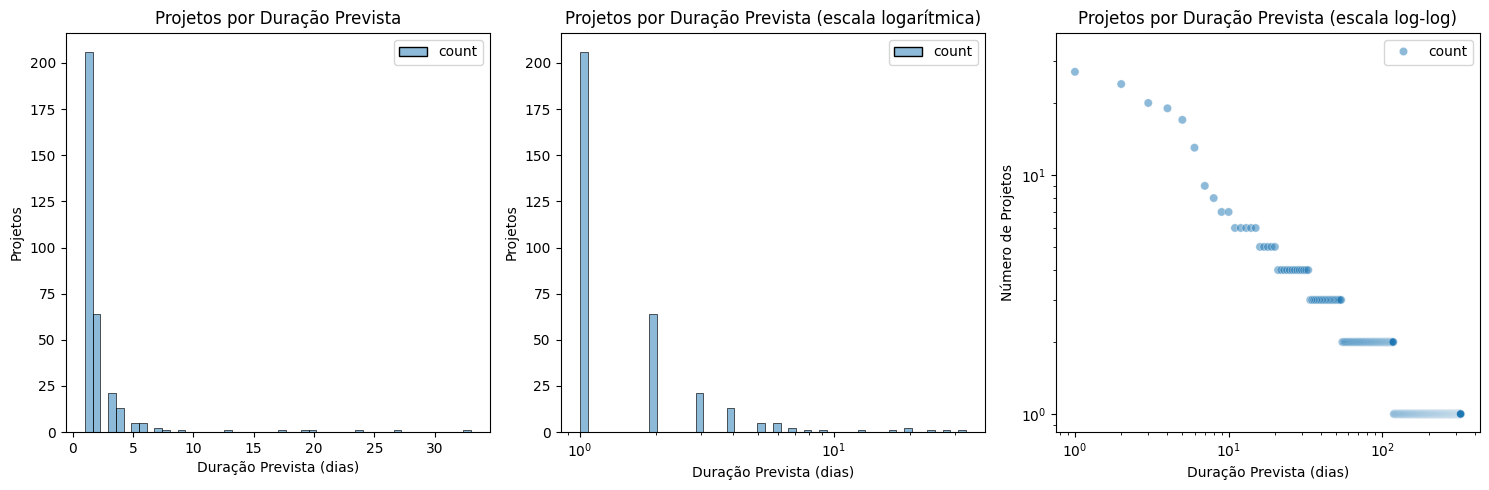

In [329]:
# Plot normal scale
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(
    data=df["duracaoPrevista"].value_counts().reset_index(),
    bins=50,
    color=palette[0],
)
plt.xlabel("Duração Prevista (dias)")
plt.ylabel("Projetos")
plt.title("Projetos por Duração Prevista")

# Plot log scale
plt.subplot(1, 3, 2)
sns.histplot(
    data=df["duracaoPrevista"].value_counts().reset_index(),
    bins=50,
    color=palette[0],
    log_scale=True,
)
plt.xlabel("Duração Prevista (dias)")
plt.ylabel("Projetos")
plt.title("Projetos por Duração Prevista (escala logarítmica)")

# Plot log-log scale
plt.subplot(1, 3, 3)
sns.scatterplot(
    data=df["duracaoPrevista"].value_counts().reset_index(), alpha=0.5, color=palette[0]
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Duração Prevista (dias)")
plt.ylabel("Número de Projetos")
plt.title("Projetos por Duração Prevista (escala log-log)")

plt.tight_layout()
plt.show()

In [330]:
duration_counts = df["duracaoPrevista"].dt.days.value_counts().head(5)
for days, count in duration_counts.items():
    print(f"{days} days ({days/365:.2f} years): {count} projects")

730.0 days (2.00 years): 33 projects
365.0 days (1.00 years): 27 projects
1461.0 days (4.00 years): 24 projects
330.0 days (0.90 years): 20 projects
400.0 days (1.10 years): 19 projects


In [331]:
df["duracaoPrevista"].dt.days.divide(365).describe().apply(lambda x: f"{x:,.2f}")

count    688.00
mean       2.06
std        1.89
min        0.00
25%        0.80
50%        1.28
75%        2.99
max       13.22
Name: duracaoPrevista, dtype: object

In [332]:
print("IQR:", calculate_iqr(df["duracaoPrevista"].dt.days.divide(365)))

IQR: 2.187671232876712


Nesse caso, parece ser uma distribuição power-law (observada como linha aproximadamente reta no gráfico log-log). Isso significa que (ainda mais do que os investimentos) a grande maioria dos projetos possui duração curta, e alguns duração extremamente longa.

Assim, é difícil dizer que haja um caso que caia 'fora da curva', pois não há um caso padrão como haveria numa distribuição normal.

Dito disso, não é incomum que projetos sejam declarados com duração exata de 1, 2, 3, 4, ou 5 anos, conforme indicado na aparente 'quantização' dos valores. Há alguns projetos declarados com duração de 364 dias em vez de 365

-   valor mínimo de 0 dias
-   valor máximo de 13 anos
-   mediana: 1.2 anos
-   IQR de 2.18 anos


In [333]:
# valores altos
df[["descricao", "duracaoPrevista", "investimentoFaixa"]].sort_values(
    by="duracaoPrevista", ascending=False
).head()

,descricao,duracaoPrevista,investimentoFaixa
497,ADEQUACAO DE TRECHO RODOVIARIO - BRASILIA - DI...,4827 days,10M-100M
633,SERVIÇO DE CONSULTORIA PARA PESQUISA DE VERIFI...,4371 days,10M-100M
538,Adequação De Trecho Rodoviário - Entrocamento ...,4197 days,100M-1B
532,CONSTRUCAO DE CONTORNO RODOVIARIO - NO MUNICIP...,3974 days,100M-1B
357,Contratos de prestação de serviços de engenhar...,3286 days,10M-100M


In [334]:
# valores baixos
df[["descricao", "duracaoPrevista", "investimentoFaixa"]].sort_values(
    by="duracaoPrevista", ascending=True
).head()

,descricao,duracaoPrevista,investimentoFaixa
304,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,0 days,1M-10M
326,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,0 days,1M-10M
331,CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,0 days,1M-10M
9,Obra no Batalhão Escola e Pronto Emprego para ...,0 days,10M-100M
287,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,1 days,1M-10M


anomalias: projetos com investimento entre 1 e 10 milhões com duração prevista de zero dias.


In [335]:
# Check if dataInicialPrevista is in the future
future_starts = df[df["dataInicialPrevista"] > pd.Timestamp.now()]
print(f"Number of projects with start date in the future: {len(future_starts)}")

Number of projects with start date in the future: 4


Devido à falta de dados para as datas reais, podemos comparar apenas as datas previstas.

Apesar de apenas 81 (11%) projetos estarem em situação 'em execução', apenas 4 projetos possuem início no futuro -- com a maioria em situação de 'cadastrado'. A documentação dos dados não entra em detalhes sobre o significado destas categorias.


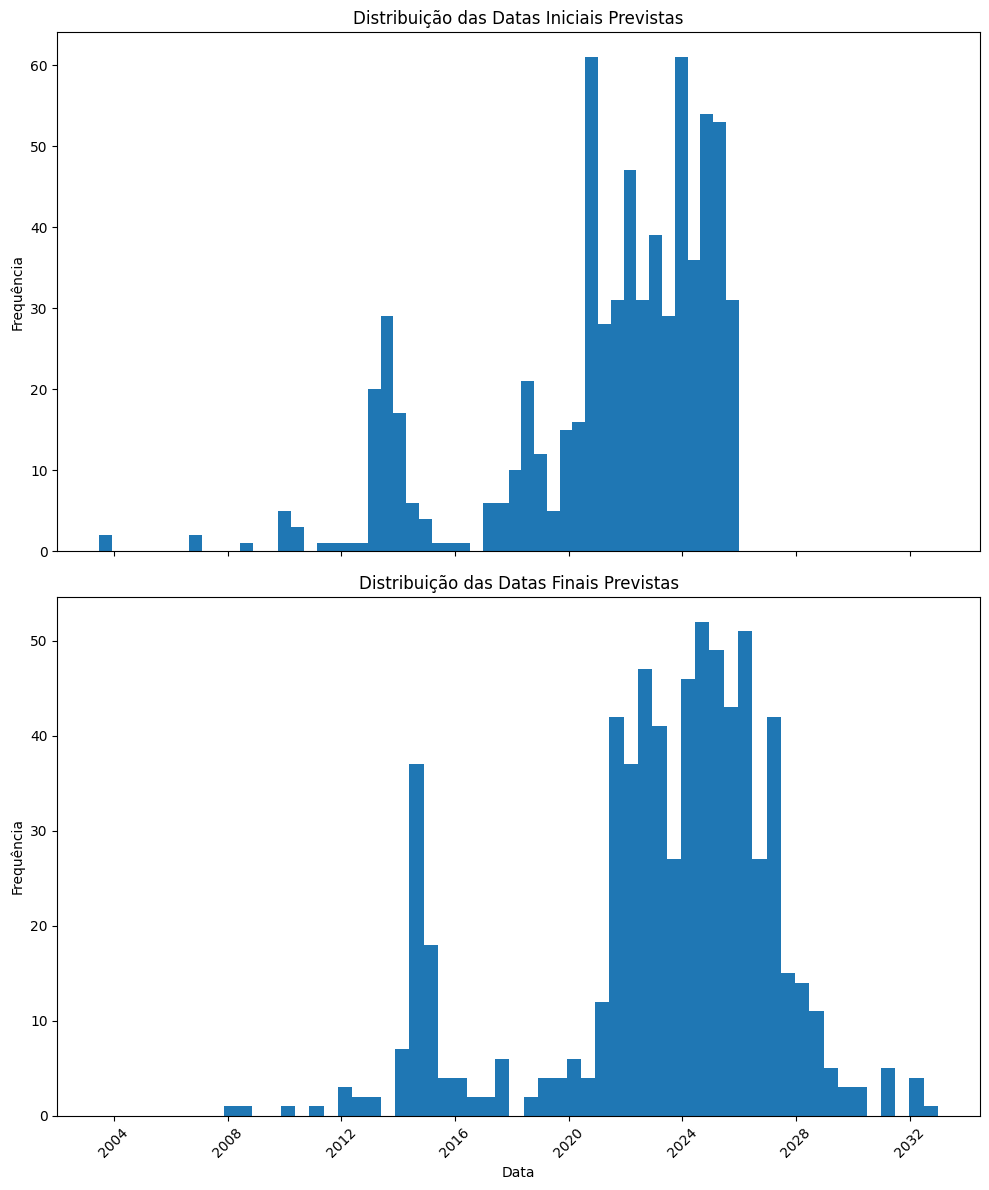

In [336]:
# Create subplots for date distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

ax1.hist(df["dataInicialPrevista"].dropna(), bins=50)
ax1.set_title("Distribuição das Datas Iniciais Previstas")
ax1.set_ylabel("Frequência")

ax2.hist(df["dataFinalPrevista"].dropna(), bins=50)
ax2.set_title("Distribuição das Datas Finais Previstas")
ax2.set_xlabel("Data")
ax2.set_ylabel("Frequência")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Houve um pico de projetos entre 2012 e 2016. Conforme esperado, a maior parte termina me menos de 2 anos


In [337]:
# check big and small date values
df[["descricao", "dataFinalPrevista"]].sort_values(
    by="dataFinalPrevista", ascending=False
).head()

,descricao,dataFinalPrevista
456,"Construção do Museu da Imagem e do Som, em Bra...",2032-12-31
682,Construção da 2ª fase do Centro de Capacitação...,2032-02-27
324,Construção da sede da Academia da Polícia Mili...,2032-02-27
302,Construção da sede do Departamento de Correiçã...,2032-02-27
663,Construção da sede da Academia da Polícia Mili...,2032-02-27


In [338]:
# check big and small date values
df[["descricao", "dataFinalPrevista"]].sort_values(
    by="dataFinalPrevista", ascending=True
).head()

,descricao,dataFinalPrevista
514,eliminação de ponto critico,2007-11-09
173,"betume, composição mistura hidrocarbonetos gas...",2008-06-27
181,Reforma da antiga biblioteca do Gama para abri...,2010-04-15
531,"Construção da Unidade Didática de Leite, inclu...",2011-01-21
533,Construção do Galpão e do Prédio do Centro Voc...,2012-02-09


In [339]:
# check big and small date values
df[["descricao", "dataInicialPrevista"]].sort_values(
    by="dataInicialPrevista", ascending=False
).head()

,descricao,dataInicialPrevista
481,obra de construção da cobertura da quadra de e...,2025-12-25
482,OBRA DE CONSTRUÇÃO DA COBERTURA DA QUADRA DE E...,2025-12-24
100,Serviços de engenharia para adequação do compl...,2025-10-13
554,Execução do Sistema de Combate a Incêndio e Pâ...,2025-10-13
145,Construção da Creche Centro de Educação para P...,2025-10-01


In [340]:
# check big and small date values
df[["descricao", "dataInicialPrevista"]].sort_values(
    by="dataInicialPrevista", ascending=True
).head()

,descricao,dataInicialPrevista
497,ADEQUACAO DE TRECHO RODOVIARIO - BRASILIA - DI...,2003-06-26
173,"betume, composição mistura hidrocarbonetos gas...",2003-06-27
514,eliminação de ponto critico,2007-01-07
494,serviços técnicos especializados no gerenciame...,2007-01-30
147,prestação de serviços técnicos prof. especiali...,2008-08-25


/home/noah-art3mis/projects/takehome-lablivre-analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/noah-art3mis/projects/takehome-lablivre-analysis/.venv/lib/python3.10/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/noah-art3mis/projects/takehome-lablivre-analysis/.venv/lib/python3.10/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
/home/noah-art3mis/projects/takehome-lablivre-analysis/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


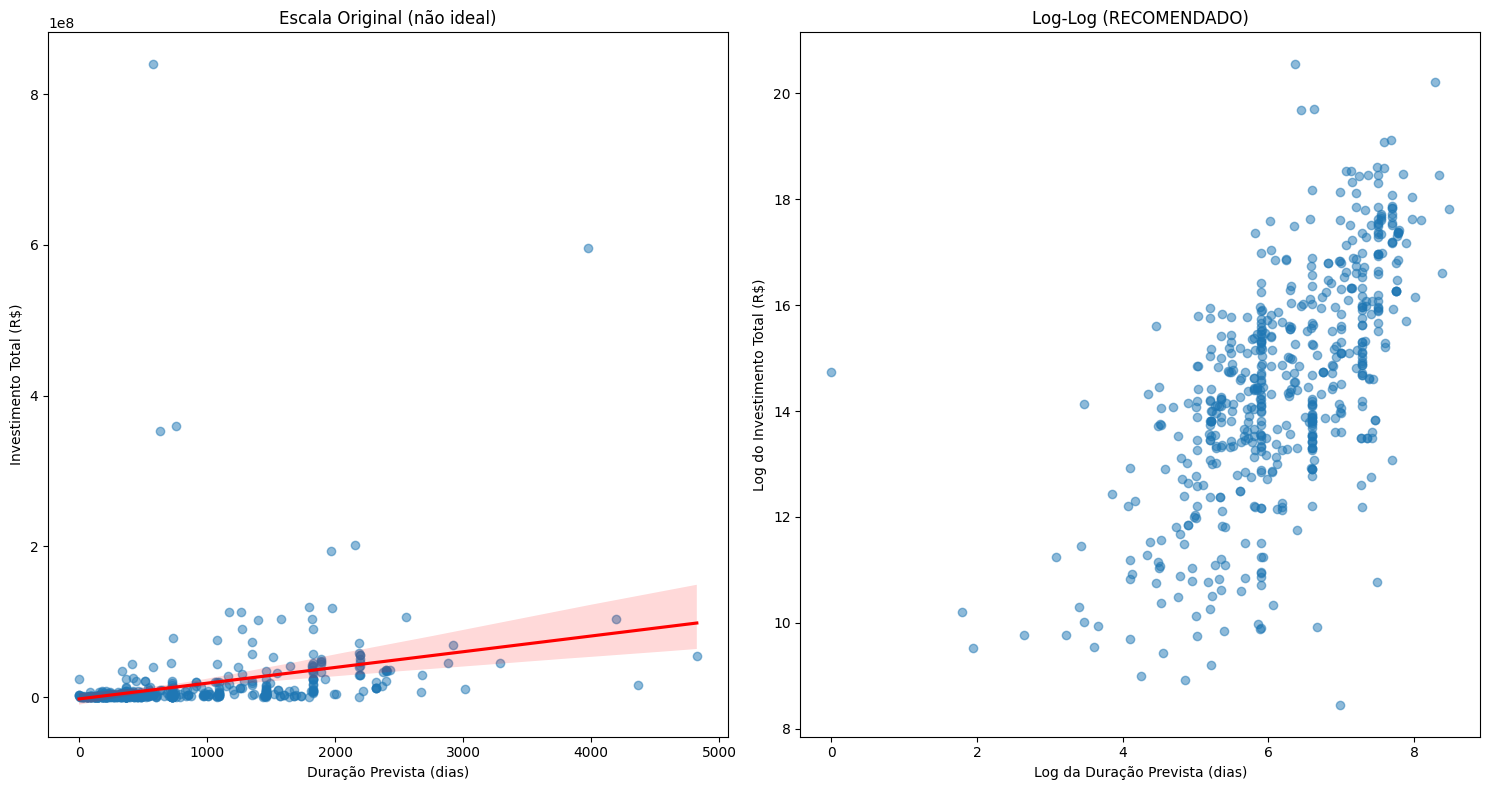

In [341]:
# Preparar dados
data_for_reg = df[~df["isInvestimentoSimbolico"]].copy()
data_for_reg = data_for_reg[
    ["idUnico", "descricao", "duracaoPrevista", "investimentoTotal"]
].dropna()
data_for_reg["duracaoPrevista_days"] = data_for_reg["duracaoPrevista"].dt.days.astype(
    int
)

# Transformações apropriadas para cada distribuição
data_for_reg["investimentoTotal_log"] = np.log(
    data_for_reg["investimentoTotal"]
)  # Log-normal
data_for_reg["duracaoPrevista_log"] = np.log(
    data_for_reg["duracaoPrevista_days"]
)  # Power-law também usa log

# Criar figura com múltiplos subplots para comparação
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# 1. Escala original (não recomendado, mas para referência)
sns.regplot(
    data=data_for_reg,
    x="duracaoPrevista_days",
    y="investimentoTotal",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
    ax=axes[0],
)
axes[0].set_title("Escala Original (não ideal)")
axes[0].set_xlabel("Duração Prevista (dias)")
axes[0].set_ylabel("Investimento Total (R$)")

# 2. Log-log (melhor para capturar ambas as distribuições)
sns.regplot(
    data=data_for_reg,
    x="duracaoPrevista_log",
    y="investimentoTotal_log",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
    ax=axes[1],
)
axes[1].set_title("Log-Log (RECOMENDADO)")
axes[1].set_xlabel("Log da Duração Prevista (dias)")
axes[1].set_ylabel("Log do Investimento Total (R$)")

plt.tight_layout()
plt.show()

In [342]:
data_for_corr = df[~df["isInvestimentoSimbolico"]].copy()
data_for_corr = data_for_corr[["duracaoPrevista", "investimentoTotal"]].dropna()
data_for_corr["duracaoPrevista_days"] = data_for_corr["duracaoPrevista"].dt.days.astype(
    int
)


pg.corr(
    data_for_corr["duracaoPrevista_days"],
    data_for_corr["investimentoTotal"],
    method="spearman",  # nao parametrico
)

,n,r,CI95%,p-val,power
spearman,569,0.648612,"[0.6, 0.69]",3.130230e-69,1.0


In [343]:
data_for_reg = data_for_reg.replace([np.inf, -np.inf], np.nan)
data_for_reg = data_for_reg.dropna()

X = sm.add_constant(data_for_reg["duracaoPrevista_log"])
y = data_for_reg["investimentoTotal_log"]
model = sm.OLS(y, X).fit()

data_for_reg["residuos"] = model.resid
data_for_reg["residuos_abs"] = np.abs(model.resid)

data_for_reg.nlargest(10, "residuos_abs").assign(
    duracaoPrevista_years=lambda x: x["duracaoPrevista_days"] / 365,
    investimentoTotal_k=lambda x: x["investimentoTotal"].apply(lambda x: f"{x:,.2f}"),
)[
    ["idUnico", "descricao", "duracaoPrevista_years", "investimentoTotal_k", "residuos"]
].round(
    {"duracaoPrevista_years": 1, "investimentoTotal_k": 0, "residuos": 1}
)

,idUnico,descricao,duracaoPrevista_years,investimentoTotal_k,residuos
287,46882.53-02,CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA...,0.0,"2,493,000.00",8.1
374,43724.53-06,Contratação de empresa do ramo de engenharia/a...,3.0,"4,684.45",-7.1
117,557.53-69,"Projeto Estratégico do SISFRON, cujo objeto é ...",1.6,"839,664,954.32",5.8
69,10613.53-07,Prestação de serviços de disponibilização de a...,4.9,"47,700.00",-5.4
646,5223.53-75,ELABORAÇÃO DE PROJETOS BÁSICO E EXECUTIVO DE P...,2.2,"20,305.41",-5.2
516,39020.52-43,"execução das obras de adequação de capacidade,...",1.7,"352,994,609.29",4.9
549,28451.53-40,ADEQUACAO DE TRECHO RODOVIARIO - ENTRONCAMENTO...,2.1,"359,130,057.13",4.6
298,1729.53-04,Prestação de serviços de elaboração de Antepro...,1.0,"19,560.00",-4.2
420,57958.53-86,Celebrar parcerias referentes ao PRONER,1.0,"20,000.00",-4.2
389,42995.53-70,Contratação de empresa especializada em arquit...,1.0,"21,560.99",-4.1


Considerando apenas os projetos com investimento significativo, podemos ver que há uma correlação entre a duração prevista e o investimento total (spearman = 0.64). Isso é esperado, pois projetos maiores tendem a durar mais. Mas com esses dados podemos calcular os projetos mais anômalos: curtos que custam muito ou demorados que custam pouco. Isso é feito usando os residuos de uma regressão linear. Com isso encontramos os itens mais anômalos, enumerados acima

Com tudo isso, encontramos os registros mais anômalos:

| ID          | Descrição                                         | Duração  | Investimento      |
| ----------- | ------------------------------------------------- | -------- | ----------------- |
| 46882.53-02 | CONSTRUÇÃO DE UNIDADE DE ATENÇÃO ESPECIALIZADA... | 1 dia    | R$ 2.493.000,00   |
| 43724.53-06 | Contratação de empresa do ramo de engenharia/a... | 3 anos   | R$ 4.684,45       |
| 557.53-69   | Projeto Estratégico do SISFRON...                 | 1.6 anos | R$ 839.664.954,32 |
| 10613.53-07 | Prestação de serviços de disponibilização de a... | 4.9 anos | R$ 47.700,00      |
| 5223.53-75  | ELABORAÇÃO DE PROJETOS BÁSICO E EXECUTIVO DE P... | 2.2 anos | R$ 20.305,41      |
| 39020.52-43 | execução das obras de adequação de capacidade,... | 1.7 anos | R$ 352.994.609,29 |
| 28451.53-40 | ADEQUACAO DE TRECHO RODOVIARIO - ENTRONCAMENTO... | 2.1 anos | R$ 359.130.057,13 |


### NLP


...


### GIS


In [344]:
total = len(df)
missing = df["cep"].isna().sum()
print(f"Missing CEP values: {missing} out of {total} ({missing/total:.1%})")

Missing CEP values: 475 out of 690 (68.8%)


In [345]:
from geocode_ceps import cep_to_coords_viacep, cep_to_coords_ipedf

ceps = df["cep"].dropna().unique()

# non-idempotent
# cep_to_coords_viacep(ceps.tolist(), "data/cep_coords_viacep.json")
# cep_to_coords_ipedf(ceps.tolist(), "data/cep_coords_ipedf.json")

In [ ]:
# avoids pandas assuming cep is a date
with open("data/cep_coords_viacep.json") as f:
    data = json.load(f)
df_viacep = pd.DataFrame.from_dict(data, orient="index")
df_viacep.columns = ["latitude", "longitude"]
print(
    f"Null records: {df_viacep['latitude'].isna().sum()} out of {len(df_viacep)} ({df_viacep['latitude'].isna().sum()/len(df_viacep):.1%})"
)

Null records: 55 out of 88 (62.5%)


In [347]:
# avoids pandas assuming cep is a date
with open("data/cep_coords_ipedf.json") as f:
    data = json.load(f)
df_ipedf = pd.DataFrame.from_dict(data, orient="index")
df_ipedf.columns = ["latitude", "longitude"]
print(
    f"Null records: {df_ipedf['latitude'].isna().sum()} out of {len(df_ipedf)} ({df_ipedf['latitude'].isna().sum()/len(df_ipedf):.1%})"
)

Null records: 47 out of 88 (53.4%)


In [348]:
pd.concat([df_viacep, df_ipedf], axis=1, keys=["viacep", "ipedf"])

viacep                 ipedf           
           latitude  longitude   latitude  longitude
70610909 -15.827093 -47.942698        NaN        NaN
70074900        NaN        NaN        NaN        NaN
70070940        NaN        NaN        NaN        NaN
73380900 -15.641667 -47.685918        NaN        NaN
71701970        NaN        NaN        NaN        NaN
...             ...        ...        ...        ...
70610907        NaN        NaN        NaN        NaN
70610600        NaN        NaN -15.780848 -47.924062
71538515        NaN        NaN        NaN        NaN
71205050 -15.793630 -47.947711 -15.797451 -47.952280
70150908 -15.794659 -47.830638        NaN        NaN

[88 rows x 4 columns]

CEP 71205050: coordenadas obtidas por metodos diferentes entram em conflito


In [ ]:
df = df.merge(
    df_viacep, left_on="cep", right_index=True, how="left", suffixes=("", "_viacep")
)

df = df.merge(
    df_ipedf, left_on="cep", right_index=True, how="left", suffixes=("", "_ipedf")
)

df = df.rename(
    columns={
        "latitude": "lat_viacep",
        "longitude": "lon_viacep",
        "latitude_ipedf": "lat_ipedf",
        "longitude_ipedf": "lon_ipedf",
    }
)

In [ ]:
# Count non-null values in both viacep and ipedf coordinates
print(
    f"Records with coordinates from both sources: {df[['lon_viacep', 'lon_ipedf']].notna().all(axis=1).sum()}"
)
df[df[["lon_viacep", "lon_ipedf"]].notna().all(axis=1)]

Records with coordinates from both sources: 29


,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,dataFinalEfetiva,dataCadastro,especie,natureza,naturezaOutras,situacao,descPlanoNacionalPoliticaVinculado,uf,qdtEmpregosGerados,descPopulacaoBeneficiada,populacaoBeneficiada,observacoesPertinentes,isModeladaPorBim,dataSituacao,textoTotal,investimentoTotal,investimentoFaixa,isInvestimentoSimbolico,duracaoPrevista,lat_viacep,lon_viacep,lat_ipedf,lon_ipedf
200,3819.53-95,Cobertura da quadra poliesportiva,70800120,"Via L4 Norte, Lote 01, Trecho 2, SCEN",Cobertura da quadra poliesportiva utilizada pe...,Melhoria das condições de uso,Cobertura da quadra poliesportiva utilizada pe...,2021-09-15,2021-11-01,NaT,NaT,2021-09-10,Ampliação,Obra,,Em execução,None,DF,NaN,None,NaN,None,<NA>,2021-09-14,Cobertura da quadra poliesportiva\n\nVia L4 No...,250000.00,100k-1M,False,47 days,-15.776029,-47.858391,-15.780920,-47.859356
202,12603.53-08,Reforma da arquibancada e pintura da pista de ...,70800120,"Via L4 Norte, Lote 01, Trecho 2, SCEN Brasíli...",Reforma da arquibancada e pintura da pista de ...,PROFESP,Reforma da arquibancada e pintura da pista de ...,2022-11-17,2022-12-09,NaT,NaT,2022-11-10,Reforma,Obra,None,Em execução,None,DF,NaN,None,NaN,None,False,2022-11-23,Reforma da arquibancada e pintura da pista de ...,75657.05,10k-100k,False,22 days,-15.776029,-47.858391,-15.780920,-47.859356
223,20084.53-55,REFORMA DA 9ª DELEGACIA DE POLÍCIA DA POLÍCIA ...,71503507,"SHIN QI 5, LOTE A – LAGO NORTE, BRASÍLIA/DF.","A Polícia Civil do Distrito Federal - PCDF, in...","A Polícia Civil do Distrito Federal - PCDF, in...","A sede da 9ª Delegacia de Polícia Civil, local...",2023-02-10,2023-12-31,NaT,NaT,2023-02-10,Reforma,Obra,None,Cadastrada,None,DF,NaN,None,NaN,None,False,2023-02-10,REFORMA DA 9ª DELEGACIA DE POLÍCIA DA POLÍCIA ...,4682173.01,1M-10M,False,324 days,-15.841496,-48.103817,-15.718002,-47.886874
239,6227.53-14,"Complementação, Reparação e Adequação da Const...",73330088,"Área Especial, qd. 02, bl. K, Setor Central - ...","Complementação, reparação e adequação da const...",Garantir segurança a pública de qualidade a to...,Conclusão da ampliação da 16ª Delegacia de Pol...,2022-06-20,2022-12-31,NaT,NaT,2022-06-20,Ampliação,Projeto,None,Cadastrada,None,DF,NaN,None,NaN,None,False,2022-06-20,"Complementação, Reparação e Adequação da Const...",65624.20,10k-100k,False,194 days,-15.625833,-47.659757,-15.625753,-47.659666
250,6419.53-39,Substituição completa dos elevadores do Edifíc...,70070040,"SAUS Quadra 4, Bloco N, Asa Sul",Contratação de empresa especializada para exec...,Melhorará as condições do prédio que estará de...,Substituição completa de 6 elevadores do Edifí...,2020-12-21,2023-02-21,NaT,NaT,2022-07-22,Reforma,Obra,None,Cadastrada,None,DF,NaN,None,NaN,None,False,2022-07-22,Substituição completa dos elevadores do Edifíc...,3490000.00,1M-10M,False,792 days,-15.801701,-47.879880,-15.803403,-47.880913
251,5589.53-35,Ampliação e modificações dos sistemas prediais...,70150900,Praça dos Três Poderes,Ampliação e modificações dos sistemas prediais...,A necessidade de criação de novas salas de tra...,"Reforma, adequação dos sistemas prediais exis...",2022-02-13,2022-08-12,NaT,NaT,2022-02-03,Reforma,Projeto,,Cadastrada,None,DF,NaN,None,NaN,None,<NA>,2022-02-03,Ampliação e modificações dos sistemas prediais...,1475909.94,1M-10M,False,180 days,-15.801159,-47.861336,-15.791780,-47.825931
253,5352.53-01,Programa de Requalificação do Arquivo Nacional...,70610460,"Setor de Indústrias Gráficas, Quadra 6 Lote 80...",Elaboração de Projetos Executivos Completos ...,Elaboração de projetos executivos visando a re...,Elaboração de projeto executivo para a realiza...,2022-03-01,2022-08-31,NaT,NaT,2021-12-21,Reforma,Projeto,,Cadastrada,Contemplada na carteira de Políticas do Minist...,DF,NaN,None,NaN,None,<NA>,2021-12-21,Programa de Requalificação do Arquivo Nacional...,750000.00,100k-1M,False,183 days,-15.787971,-47.910044,-15.795082,-47.915712
2

Usando APIs oficiais do governo, elas parecem ter dificuldade de usar os CEPs para obter as coordenadas dos locais. Ambos os metodos só encontraram cerca de metade dos 88 CEPs presentes dos dados.


In [351]:
import folium

# Create map centered on DF
m = folium.Map(location=[-15.7942, -47.8822], zoom_start=10)

# Add ViaCEP markers (blue)
for cep, row in df_viacep.dropna().iterrows():
    if row["latitude"] is not None and row["longitude"] is not None:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,
            color="blue",
            fill=True,
            popup=f"ViaCEP: {cep}",
        ).add_to(m)

# Add IPEDF markers (red)
for cep, row in df_ipedf.dropna().iterrows():
    if row["latitude"] is not None and row["longitude"] is not None:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=5,
            color="red",
            fill=True,
            popup=f"IPEDF: {cep}",
        ).add_to(m)

m

Esta amostra representa algum tipo de viés de seleção -- primeiro dos registros com CEP e depois dos CEPs com coordenadas. Em vermelho estão as coordenadas obtidas via ViaCEP e em azul estão as coordernadas obtidas via Nominatim usando o serviço de cep do IPEDF. Dos 88 CEPs válidos, as ferramentas de geocodificação do governo só encontraram coordenadas para 41 e 33, respectivamente; 29 foram encontrados por ambas -- o que não significa que eles encontraram as mesmas coordenadas.

## Relatório


Vários campos tem problema sistemáticos. Talvez o formulário seja confuso, talvez falte masking, talvez o campo não se aplique a um projeto. Isso precisaria ser investigado melhor. Para detalhes, ver seção `3.2 Qualidade`.

Em termos de

Os investimentos revelaram uma categoria implícita de investimento simbólico.

Atenção aos maiores investimentos também é relevante.


## Conclusão
